# Computer Vision 2023 Assignment 3: Deep Learning for Perception Tasks

This assignment contains 2 questions. The first question probes understanding of deep learning for classification. The second question is a more challenging classification experiment on a larger dataset. Answer the questions in separate Python notebooks.

## Question 1: A simple classifier, 20 marks

For this exercise, we provide demo code showing how to train a network on a small dataset called [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). Please run through the code "tutorial-style" to get a sense of what it is doing. Then use the code alongside lecture notes and other resources to understand how to use pytorch libraries to implement, train and use a neural network.

For the Fashion-MNIST dataset the lables from 0-9 correspond to various clothing classes so you might find it convenient to create a python list as follows:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

You will need to answer various questions about the system, how it operates, the results of experiments with it and make modifications to it yourself. You can change the training scheme and the network structure. 

Organize your own text and code cell to show the answer of each questions.

Detailed requirements:

**Q1.1 (1 point)**

Extract 3 images of different types of clothing from the training dataset, print out the size/shape of the training images, and display the three with their corresponding labels. 

**Q1.2 (2 points)** 

Run the training code for 10 epochs, for different values of the learning rate. Fill in the table below and plot the loss curves for each experiment:

|Lr|Accuracy|
|---|---|
|1   |   19.8   |
|0.1|    87.3      |
|0.01|    83.2     |
|0.001  |   71.1     |


**Q1.3 (3 points)** 

Report the number of epochs when the accuracy reaches 85%. Fill in the table below and plot the loass curve for each experiment:

|Lr|Accuracy|Epoch|
|---|---|---|
|1   |  10.0-20.7    |  Nan   |
|0.1|   85.0       | 4   |
|0.01|    85.2     |  17  |
|0.001  |   85.0     |   120  |


**Q1.4 (2 points)** 

Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?


**Q1.5 (5 points)** 

Build a wider network by modifying the code that constructs the network so that the hidden layer(s) contain more perceptrons, and record the accuracy along with the number of trainable parameters in your model.  Now modify the oroginal network to be deeper instead of wider (i.e. by adding more hidden layers). Record your accuracy and network size findings. Plot the loss curve for each experiment. Write down your conclusions about changing the network structure?  

|Structures|Accuracy|Parameters|
|---|---|---|
|Base   |   87.3   |669706|
|Deeper|     86.6     |798474|
|Wider|     87.5    |1863690|


**Q1.6 (2 points)** 

Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). Hint: the mean of the gradients decrease.

For more exlanation of q1.7, you could refer to the following simple instructions: https://colab.research.google.com/drive/1XAsyNegGSvMf3_B6MrsXht7-fHqtJ7OW?usp=sharing

**Q1.7 (5 points)** 

Modify the network structure and training/test to use a small convolutional neural network instead of an MLP. Discuss your findings with rehgard to convergence, accuracy and number of parameters, relative to MLPs.  

Hint: Look at the structure of the CNN in the Workshop 3 examples.

In [36]:
# import numpy as np # This is for mathematical operations

# this is used in plotting 
import matplotlib.pyplot as plt 
import time
import pylab as pl
from IPython import display

%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. 
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets. 
##Every TorchVision Dataset includes two arguments: 
##transform and target_transform to modify the samples and labels respectively.

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

**NOTE**: For consistency with the original data set, we call our validation data "test_data". It is important to keep in mind though that we are using the data for model validation and not for testing the final, trained model (which requires data not used when training the model parameters). 

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset and supports automatic batching, sampling, shuffling, and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [146]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


Add in a code cell to inspect the training data, as per Q1.1. Each element of the training_data structure has a greyscale image (which you can use plt.imshow(img[0,:,:]) to display, just like you did in previous assignments.  

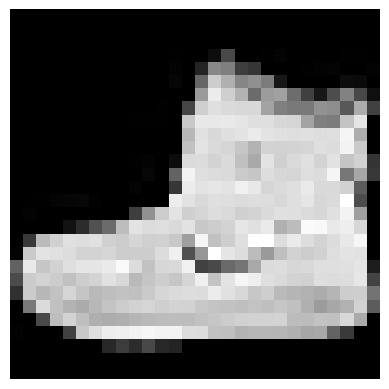

In [147]:
# Code cell for training image display
img_index = 0  
img, label = training_data[img_index]
plt.imshow(img[0,:,:], cmap='gray')
plt.axis('off')
plt.show()

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the init function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [99]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters:", total_params)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Total Trainable Parameters: 669706


In [38]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [105]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [106]:
##Define a test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss,correct

In [24]:
#Train and test the model
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298520  [    0/60000]
loss: 2.285323  [ 6400/60000]
loss: 2.264351  [12800/60000]
loss: 2.266253  [19200/60000]
loss: 2.244990  [25600/60000]
loss: 2.225540  [32000/60000]
loss: 2.223236  [38400/60000]
loss: 2.193966  [44800/60000]
loss: 2.194777  [51200/60000]
loss: 2.167247  [57600/60000]
Test Error: 
 Accuracy: 53.1%, Avg loss: 2.152243 

Epoch 2
-------------------------------
loss: 2.160160  [    0/60000]
loss: 2.147828  [ 6400/60000]
loss: 2.089111  [12800/60000]
loss: 2.118133  [19200/60000]
loss: 2.060937  [25600/60000]
loss: 2.002837  [32000/60000]
loss: 2.029651  [38400/60000]
loss: 1.950569  [44800/60000]
loss: 1.968227  [51200/60000]
loss: 1.900613  [57600/60000]
Test Error: 
 Accuracy: 60.6%, Avg loss: 1.886415 

Epoch 3
-------------------------------
loss: 1.915884  [    0/60000]
loss: 1.882141  [ 6400/60000]
loss: 1.765858  [12800/60000]
loss: 1.822511  [19200/60000]
loss: 1.705983  [25600/60000]
loss: 1.654059  [32000/600

size: 60000
shape: torch.Size([60000, 28, 28])
label_shape: torch.Size([60000])
label_number: 10
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2])


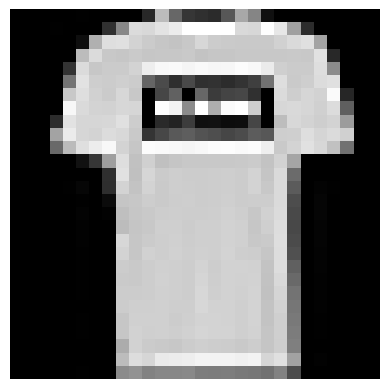

0


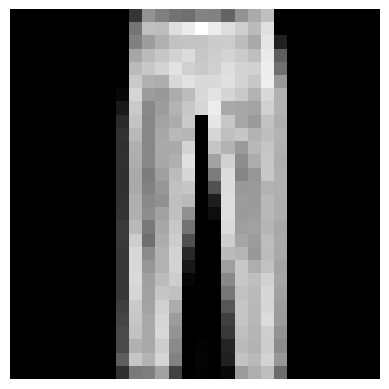

1


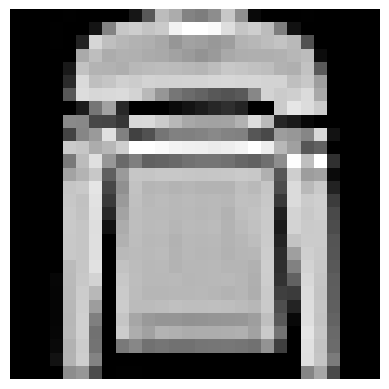

2


In [55]:
#Code for question1.1
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
print("size:", len(training_data))
print("shape:", training_data.data.shape)
print("label_shape:", training_data.targets.shape)
print("label_number:", len(training_data.classes))
labels = training_data.targets
unique_labels = torch.unique(labels)
print(unique_labels)
select_labels=unique_labels[0:3]
print(select_labels)
images=[]
im1=[]
im2=[]
im3=[]
for i in range(len(training_data)):
    if training_data[i][1]==0:
        im1.append(training_data[i])
    elif training_data[i][1]==1:
        im2.append(training_data[i])
    elif training_data[i][1]==2:
        im3.append(training_data[i])
images.append(im1[0])
images.append(im2[0])
images.append(im3[0])
img_index = 0  
img,label = images[img_index]
plt.imshow(img[0,:,:], cmap='gray')
plt.axis('off')
plt.show()
print(label)
img_index = 1
img, label = images[img_index]
plt.imshow(img[0,:,:], cmap='gray')
plt.axis('off')
plt.show()
print(label)
img_index = 2
img, label = images[img_index]
plt.imshow(img[0,:,:], cmap='gray')
plt.axis('off')
plt.show()
print(label)

In [69]:
#code for question 1.2
losses = []
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss = test(test_dataloader, model, loss_fn)
    losses.append(loss)

Epoch 1
-------------------------------
loss: 2.300789  [    0/60000]
loss: 3.457046  [ 6400/60000]
loss: 2.327987  [12800/60000]
loss: 1.858342  [19200/60000]
loss: 1.811761  [25600/60000]
loss: 1.724597  [32000/60000]
loss: 1.700926  [38400/60000]
loss: 1.711275  [44800/60000]
loss: 1.657892  [51200/60000]
loss: 1.689269  [57600/60000]
Test Error: 
 Accuracy: 20.0%, Avg loss: 1.701855 

Epoch 2
-------------------------------
loss: 1.680199  [    0/60000]
loss: 1.686081  [ 6400/60000]
loss: 1.739178  [12800/60000]
loss: 1.822188  [19200/60000]
loss: 1.772454  [25600/60000]
loss: 1.754710  [32000/60000]
loss: 1.705502  [38400/60000]
loss: 1.457183  [44800/60000]
loss: 1.649590  [51200/60000]
loss: 1.659614  [57600/60000]
Test Error: 
 Accuracy: 20.1%, Avg loss: 1.823084 

Epoch 3
-------------------------------
loss: 1.759024  [    0/60000]
loss: 1.643453  [ 6400/60000]
loss: 1.736741  [12800/60000]
loss: 1.668282  [19200/60000]
loss: 1.828320  [25600/60000]
loss: 1.774383  [32000/600

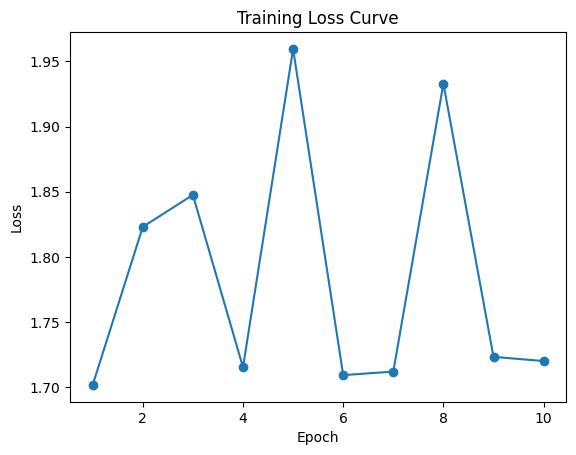

In [71]:
plt.plot(range(1, epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [75]:
losses = []
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss = test(test_dataloader, model, loss_fn)
    losses.append(loss)

Epoch 1
-------------------------------
loss: 2.308426  [    0/60000]
loss: 0.898664  [ 6400/60000]
loss: 0.574847  [12800/60000]
loss: 0.725962  [19200/60000]
loss: 0.592252  [25600/60000]
loss: 0.506215  [32000/60000]
loss: 0.537008  [38400/60000]
loss: 0.592733  [44800/60000]
loss: 0.613278  [51200/60000]
loss: 0.451039  [57600/60000]
Test Error: 
 Accuracy: 79.0%, Avg loss: 0.554276 

Epoch 2
-------------------------------
loss: 0.437682  [    0/60000]
loss: 0.443061  [ 6400/60000]
loss: 0.373202  [12800/60000]
loss: 0.439612  [19200/60000]
loss: 0.401262  [25600/60000]
loss: 0.448174  [32000/60000]
loss: 0.408267  [38400/60000]
loss: 0.516229  [44800/60000]
loss: 0.510745  [51200/60000]
loss: 0.419899  [57600/60000]
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.476883 

Epoch 3
-------------------------------
loss: 0.331300  [    0/60000]
loss: 0.357865  [ 6400/60000]
loss: 0.317665  [12800/60000]
loss: 0.360228  [19200/60000]
loss: 0.341693  [25600/60000]
loss: 0.418307  [32000/600

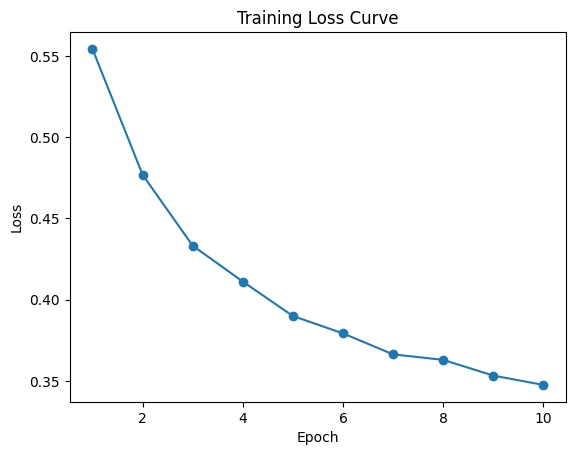

In [76]:
plt.plot(range(1, epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [81]:
losses = []
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss = test(test_dataloader, model, loss_fn)
    losses.append(loss)

Epoch 1
-------------------------------
loss: 2.303613  [    0/60000]
loss: 2.163389  [ 6400/60000]
loss: 1.803041  [12800/60000]
loss: 1.505120  [19200/60000]
loss: 1.159484  [25600/60000]
loss: 1.055620  [32000/60000]
loss: 1.009546  [38400/60000]
loss: 0.864177  [44800/60000]
loss: 0.886052  [51200/60000]
loss: 0.808347  [57600/60000]
Test Error: 
 Accuracy: 71.2%, Avg loss: 0.794302 

Epoch 2
-------------------------------
loss: 0.795051  [    0/60000]
loss: 0.850702  [ 6400/60000]
loss: 0.584835  [12800/60000]
loss: 0.782208  [19200/60000]
loss: 0.665936  [25600/60000]
loss: 0.646174  [32000/60000]
loss: 0.720465  [38400/60000]
loss: 0.679714  [44800/60000]
loss: 0.709282  [51200/60000]
loss: 0.641554  [57600/60000]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.637269 

Epoch 3
-------------------------------
loss: 0.570789  [    0/60000]
loss: 0.660285  [ 6400/60000]
loss: 0.436693  [12800/60000]
loss: 0.666538  [19200/60000]
loss: 0.589266  [25600/60000]
loss: 0.568355  [32000/600

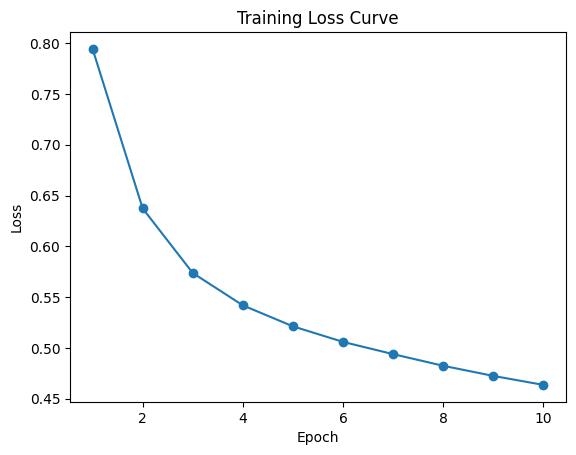

In [82]:
plt.plot(range(1, epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [86]:
losses = []
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss = test(test_dataloader, model, loss_fn)
    losses.append(loss)

Epoch 1
-------------------------------
loss: 2.300165  [    0/60000]
loss: 2.284601  [ 6400/60000]
loss: 2.266656  [12800/60000]
loss: 2.265265  [19200/60000]
loss: 2.240025  [25600/60000]
loss: 2.213260  [32000/60000]
loss: 2.225255  [38400/60000]
loss: 2.187065  [44800/60000]
loss: 2.195795  [51200/60000]
loss: 2.152463  [57600/60000]
Test Error: 
 Accuracy: 41.1%, Avg loss: 2.150631 

Epoch 2
-------------------------------
loss: 2.160432  [    0/60000]
loss: 2.148810  [ 6400/60000]
loss: 2.093259  [12800/60000]
loss: 2.107784  [19200/60000]
loss: 2.054480  [25600/60000]
loss: 1.994823  [32000/60000]
loss: 2.017271  [38400/60000]
loss: 1.938818  [44800/60000]
loss: 1.959037  [51200/60000]
loss: 1.861998  [57600/60000]
Test Error: 
 Accuracy: 59.7%, Avg loss: 1.875245 

Epoch 3
-------------------------------
loss: 1.908182  [    0/60000]
loss: 1.876211  [ 6400/60000]
loss: 1.762657  [12800/60000]
loss: 1.794682  [19200/60000]
loss: 1.688977  [25600/60000]
loss: 1.641677  [32000/600

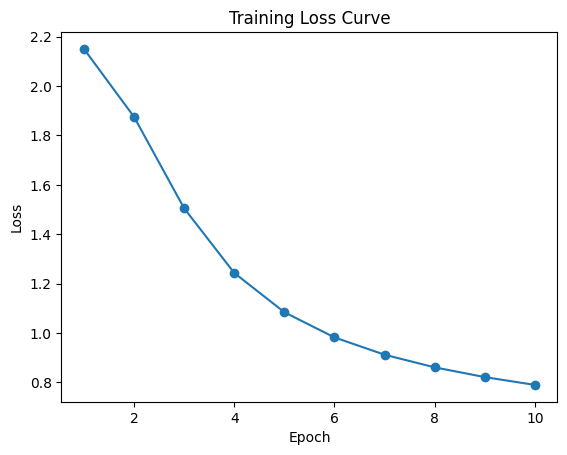

In [87]:
plt.plot(range(1, epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [104]:
#code for question 1.3
losses = []
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss,accuracy = test(test_dataloader, model, loss_fn)
    losses.append(loss)
    if accuracy>=0.85:
        break

Epoch 1
-------------------------------
loss: 2.298406  [    0/60000]
loss: 1.939781  [ 6400/60000]
loss: 1.825169  [12800/60000]
loss: 1.454690  [19200/60000]
loss: 1.793104  [25600/60000]
loss: 1.890293  [32000/60000]
loss: 1.705379  [38400/60000]
loss: 1.625860  [44800/60000]
loss: 1.696273  [51200/60000]
loss: 1.631885  [57600/60000]
Test Error: 
 Accuracy: 20.7%, Avg loss: 1.747973 

Epoch 2
-------------------------------
loss: 1.785257  [    0/60000]
loss: 1.677019  [ 6400/60000]
loss: 1.790307  [12800/60000]
loss: 1.799545  [19200/60000]
loss: 1.448986  [25600/60000]
loss: 1.714263  [32000/60000]
loss: 1.544805  [38400/60000]
loss: 1.759948  [44800/60000]
loss: 1.663105  [51200/60000]
loss: 1.672362  [57600/60000]
Test Error: 
 Accuracy: 20.0%, Avg loss: 1.704452 

Epoch 3
-------------------------------
loss: 1.718217  [    0/60000]
loss: 1.670483  [ 6400/60000]
loss: 1.763575  [12800/60000]
loss: 1.678757  [19200/60000]
loss: 1.677581  [25600/60000]
loss: 1.750289  [32000/600

loss: 1.689298  [ 6400/60000]
loss: 1.700085  [12800/60000]
loss: 1.746101  [19200/60000]
loss: 1.670526  [25600/60000]
loss: 1.721203  [32000/60000]
loss: 2.055944  [38400/60000]
loss: 2.126494  [44800/60000]
loss: 1.997346  [51200/60000]
loss: 2.066105  [57600/60000]
Test Error: 
 Accuracy: 18.5%, Avg loss: 2.064946 

Epoch 23
-------------------------------
loss: 2.100077  [    0/60000]
loss: 1.812885  [ 6400/60000]
loss: 1.896050  [12800/60000]
loss: 1.952951  [19200/60000]
loss: 2.106313  [25600/60000]
loss: 1.761659  [32000/60000]
loss: 2.307550  [38400/60000]
loss: 2.288610  [44800/60000]
loss: 2.300421  [51200/60000]
loss: 2.330204  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.305845 

Epoch 24
-------------------------------
loss: 2.313046  [    0/60000]
loss: 2.306795  [ 6400/60000]
loss: 2.312776  [12800/60000]
loss: 2.304621  [19200/60000]
loss: 2.281377  [25600/60000]
loss: 2.304950  [32000/60000]
loss: 2.305945  [38400/60000]
loss: 2.288610  [44800/60000]
loss

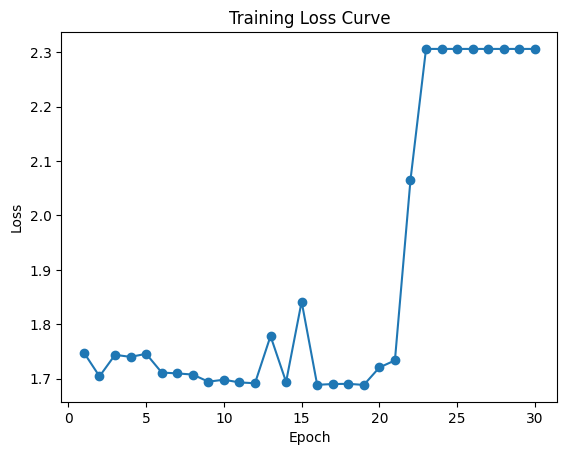

In [105]:
plt.plot(range(1, epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [109]:
losses = []
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss,accuracy = test(test_dataloader, model, loss_fn)
    losses.append(loss)
    if accuracy>=0.85:
        break

Epoch 1
-------------------------------
loss: 2.307095  [    0/60000]
loss: 0.909839  [ 6400/60000]
loss: 0.588225  [12800/60000]
loss: 0.715487  [19200/60000]
loss: 0.603918  [25600/60000]
loss: 0.506992  [32000/60000]
loss: 0.535688  [38400/60000]
loss: 0.596213  [44800/60000]
loss: 0.615340  [51200/60000]
loss: 0.451781  [57600/60000]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.554144 

Epoch 2
-------------------------------
loss: 0.441613  [    0/60000]
loss: 0.432551  [ 6400/60000]
loss: 0.364211  [12800/60000]
loss: 0.436951  [19200/60000]
loss: 0.414820  [25600/60000]
loss: 0.438897  [32000/60000]
loss: 0.406148  [38400/60000]
loss: 0.498841  [44800/60000]
loss: 0.508832  [51200/60000]
loss: 0.416277  [57600/60000]
Test Error: 
 Accuracy: 82.5%, Avg loss: 0.468526 

Epoch 3
-------------------------------
loss: 0.327046  [    0/60000]
loss: 0.354691  [ 6400/60000]
loss: 0.307137  [12800/60000]
loss: 0.362279  [19200/60000]
loss: 0.349934  [25600/60000]
loss: 0.403979  [32000/600

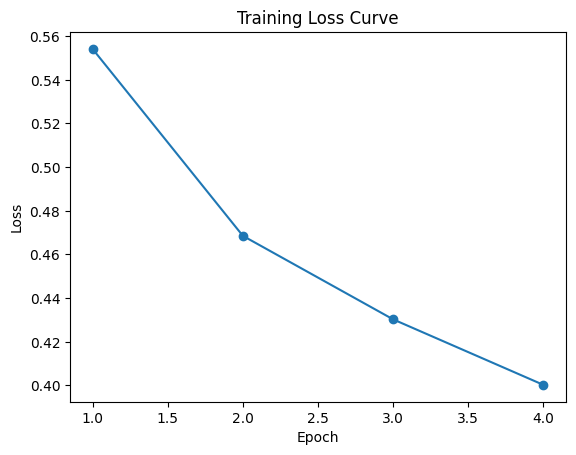

In [111]:
plt.plot(range(1, 5), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [115]:
losses = []
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss,accuracy = test(test_dataloader, model, loss_fn)
    losses.append(loss)
    if accuracy>=0.85:
        break

Epoch 1
-------------------------------
loss: 2.317503  [    0/60000]
loss: 2.167695  [ 6400/60000]
loss: 1.809497  [12800/60000]
loss: 1.509888  [19200/60000]
loss: 1.147692  [25600/60000]
loss: 1.057303  [32000/60000]
loss: 1.011451  [38400/60000]
loss: 0.870990  [44800/60000]
loss: 0.873955  [51200/60000]
loss: 0.817020  [57600/60000]
Test Error: 
 Accuracy: 70.9%, Avg loss: 0.799516 

Epoch 2
-------------------------------
loss: 0.798313  [    0/60000]
loss: 0.858873  [ 6400/60000]
loss: 0.599378  [12800/60000]
loss: 0.788364  [19200/60000]
loss: 0.655564  [25600/60000]
loss: 0.638938  [32000/60000]
loss: 0.703215  [38400/60000]
loss: 0.683855  [44800/60000]
loss: 0.690665  [51200/60000]
loss: 0.634622  [57600/60000]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.637581 

Epoch 3
-------------------------------
loss: 0.565197  [    0/60000]
loss: 0.663491  [ 6400/60000]
loss: 0.444509  [12800/60000]
loss: 0.673222  [19200/60000]
loss: 0.578515  [25600/60000]
loss: 0.555186  [32000/600

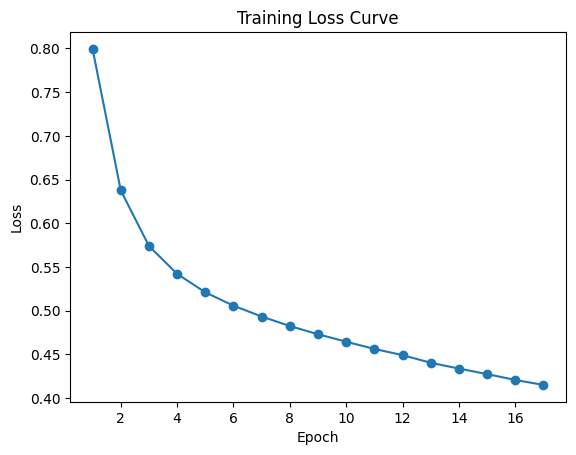

In [117]:
plt.plot(range(1, 18), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [121]:
losses = []
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss,accuracy = test(test_dataloader, model, loss_fn)
    losses.append(loss)
    if accuracy>=0.85:
        break

Epoch 1
-------------------------------
loss: 2.304540  [    0/60000]
loss: 2.285547  [ 6400/60000]
loss: 2.265503  [12800/60000]
loss: 2.253840  [19200/60000]
loss: 2.232651  [25600/60000]
loss: 2.213239  [32000/60000]
loss: 2.206540  [38400/60000]
loss: 2.177657  [44800/60000]
loss: 2.182170  [51200/60000]
loss: 2.133466  [57600/60000]
Test Error: 
 Accuracy: 50.4%, Avg loss: 2.134931 

Epoch 2
-------------------------------
loss: 2.157035  [    0/60000]
loss: 2.136670  [ 6400/60000]
loss: 2.075629  [12800/60000]
loss: 2.083957  [19200/60000]
loss: 2.021820  [25600/60000]
loss: 1.973156  [32000/60000]
loss: 1.986270  [38400/60000]
loss: 1.910672  [44800/60000]
loss: 1.928576  [51200/60000]
loss: 1.827210  [57600/60000]
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.841932 

Epoch 3
-------------------------------
loss: 1.888944  [    0/60000]
loss: 1.845117  [ 6400/60000]
loss: 1.732115  [12800/60000]
loss: 1.768230  [19200/60000]
loss: 1.643775  [25600/60000]
loss: 1.614583  [32000/600

loss: 0.633933  [ 6400/60000]
loss: 0.423235  [12800/60000]
loss: 0.693684  [19200/60000]
loss: 0.608563  [25600/60000]
loss: 0.589489  [32000/60000]
loss: 0.622517  [38400/60000]
loss: 0.676830  [44800/60000]
loss: 0.655664  [51200/60000]
loss: 0.608619  [57600/60000]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.601042 

Epoch 23
-------------------------------
loss: 0.516047  [    0/60000]
loss: 0.622148  [ 6400/60000]
loss: 0.414220  [12800/60000]
loss: 0.684820  [19200/60000]
loss: 0.601456  [25600/60000]
loss: 0.583460  [32000/60000]
loss: 0.610830  [38400/60000]
loss: 0.672936  [44800/60000]
loss: 0.651343  [51200/60000]
loss: 0.598871  [57600/60000]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.592492 

Epoch 24
-------------------------------
loss: 0.504203  [    0/60000]
loss: 0.611276  [ 6400/60000]
loss: 0.405893  [12800/60000]
loss: 0.676383  [19200/60000]
loss: 0.594641  [25600/60000]
loss: 0.577834  [32000/60000]
loss: 0.599981  [38400/60000]
loss: 0.669845  [44800/60000]
loss

loss: 0.503362  [ 6400/60000]
loss: 0.319938  [12800/60000]
loss: 0.567766  [19200/60000]
loss: 0.484987  [25600/60000]
loss: 0.493475  [32000/60000]
loss: 0.487667  [38400/60000]
loss: 0.667105  [44800/60000]
loss: 0.616062  [51200/60000]
loss: 0.463622  [57600/60000]
Test Error: 
 Accuracy: 82.0%, Avg loss: 0.503205 

Epoch 44
-------------------------------
loss: 0.369995  [    0/60000]
loss: 0.500390  [ 6400/60000]
loss: 0.317378  [12800/60000]
loss: 0.563826  [19200/60000]
loss: 0.480629  [25600/60000]
loss: 0.489918  [32000/60000]
loss: 0.484546  [38400/60000]
loss: 0.666707  [44800/60000]
loss: 0.614469  [51200/60000]
loss: 0.459655  [57600/60000]
Test Error: 
 Accuracy: 82.1%, Avg loss: 0.500885 

Epoch 45
-------------------------------
loss: 0.365938  [    0/60000]
loss: 0.497556  [ 6400/60000]
loss: 0.314931  [12800/60000]
loss: 0.560002  [19200/60000]
loss: 0.476433  [25600/60000]
loss: 0.486554  [32000/60000]
loss: 0.481603  [38400/60000]
loss: 0.666117  [44800/60000]
loss

In [122]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss,accuracy = test(test_dataloader, model, loss_fn)
    losses.append(loss)
    if accuracy>=0.85:
        break

Epoch 1
-------------------------------
loss: 0.344601  [    0/60000]
loss: 0.482886  [ 6400/60000]
loss: 0.302215  [12800/60000]
loss: 0.540035  [19200/60000]
loss: 0.454177  [25600/60000]
loss: 0.469070  [32000/60000]
loss: 0.466863  [38400/60000]
loss: 0.659998  [44800/60000]
loss: 0.603401  [51200/60000]
loss: 0.436971  [57600/60000]
Test Error: 
 Accuracy: 82.6%, Avg loss: 0.487041 

Epoch 2
-------------------------------
loss: 0.341444  [    0/60000]
loss: 0.480729  [ 6400/60000]
loss: 0.300395  [12800/60000]
loss: 0.537127  [19200/60000]
loss: 0.450891  [25600/60000]
loss: 0.466536  [32000/60000]
loss: 0.464754  [38400/60000]
loss: 0.658710  [44800/60000]
loss: 0.601874  [51200/60000]
loss: 0.434399  [57600/60000]
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.485330 

Epoch 3
-------------------------------
loss: 0.338396  [    0/60000]
loss: 0.478675  [ 6400/60000]
loss: 0.298627  [12800/60000]
loss: 0.534309  [19200/60000]
loss: 0.447681  [25600/60000]
loss: 0.464103  [32000/600

loss: 0.446471  [ 6400/60000]
loss: 0.273282  [12800/60000]
loss: 0.494127  [19200/60000]
loss: 0.400116  [25600/60000]
loss: 0.431669  [32000/60000]
loss: 0.434086  [38400/60000]
loss: 0.625553  [44800/60000]
loss: 0.569930  [51200/60000]
loss: 0.402960  [57600/60000]
Test Error: 
 Accuracy: 83.6%, Avg loss: 0.458998 

Epoch 23
-------------------------------
loss: 0.293618  [    0/60000]
loss: 0.444986  [ 6400/60000]
loss: 0.272338  [12800/60000]
loss: 0.492569  [19200/60000]
loss: 0.398151  [25600/60000]
loss: 0.430436  [32000/60000]
loss: 0.432909  [38400/60000]
loss: 0.624005  [44800/60000]
loss: 0.568377  [51200/60000]
loss: 0.401984  [57600/60000]
Test Error: 
 Accuracy: 83.6%, Avg loss: 0.457941 

Epoch 24
-------------------------------
loss: 0.291973  [    0/60000]
loss: 0.443550  [ 6400/60000]
loss: 0.271379  [12800/60000]
loss: 0.491019  [19200/60000]
loss: 0.396221  [25600/60000]
loss: 0.429241  [32000/60000]
loss: 0.431769  [38400/60000]
loss: 0.622479  [44800/60000]
loss

loss: 0.418617  [ 6400/60000]
loss: 0.255819  [12800/60000]
loss: 0.464247  [19200/60000]
loss: 0.364788  [25600/60000]
loss: 0.409263  [32000/60000]
loss: 0.413208  [38400/60000]
loss: 0.596119  [44800/60000]
loss: 0.541153  [51200/60000]
loss: 0.387235  [57600/60000]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.439933 

Epoch 44
-------------------------------
loss: 0.266652  [    0/60000]
loss: 0.417394  [ 6400/60000]
loss: 0.255161  [12800/60000]
loss: 0.462969  [19200/60000]
loss: 0.363425  [25600/60000]
loss: 0.408291  [32000/60000]
loss: 0.412185  [38400/60000]
loss: 0.595005  [44800/60000]
loss: 0.539881  [51200/60000]
loss: 0.386691  [57600/60000]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.439152 

Epoch 45
-------------------------------
loss: 0.265685  [    0/60000]
loss: 0.416146  [ 6400/60000]
loss: 0.254499  [12800/60000]
loss: 0.461715  [19200/60000]
loss: 0.362067  [25600/60000]
loss: 0.407301  [32000/60000]
loss: 0.411095  [38400/60000]
loss: 0.593929  [44800/60000]
loss

In [123]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss,accuracy = test(test_dataloader, model, loss_fn)
    losses.append(loss)
    if accuracy>=0.85:
        break

Epoch 1
-------------------------------
loss: 0.260494  [    0/60000]
loss: 0.408835  [ 6400/60000]
loss: 0.250325  [12800/60000]
loss: 0.454397  [19200/60000]
loss: 0.354677  [25600/60000]
loss: 0.401491  [32000/60000]
loss: 0.405057  [38400/60000]
loss: 0.587352  [44800/60000]
loss: 0.531559  [51200/60000]
loss: 0.383180  [57600/60000]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.433865 

Epoch 2
-------------------------------
loss: 0.259720  [    0/60000]
loss: 0.407630  [ 6400/60000]
loss: 0.249706  [12800/60000]
loss: 0.453252  [19200/60000]
loss: 0.353562  [25600/60000]
loss: 0.400520  [32000/60000]
loss: 0.404164  [38400/60000]
loss: 0.586314  [44800/60000]
loss: 0.530584  [51200/60000]
loss: 0.382768  [57600/60000]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.433123 

Epoch 3
-------------------------------
loss: 0.258956  [    0/60000]
loss: 0.406446  [ 6400/60000]
loss: 0.249102  [12800/60000]
loss: 0.452031  [19200/60000]
loss: 0.352452  [25600/60000]
loss: 0.399683  [32000/600

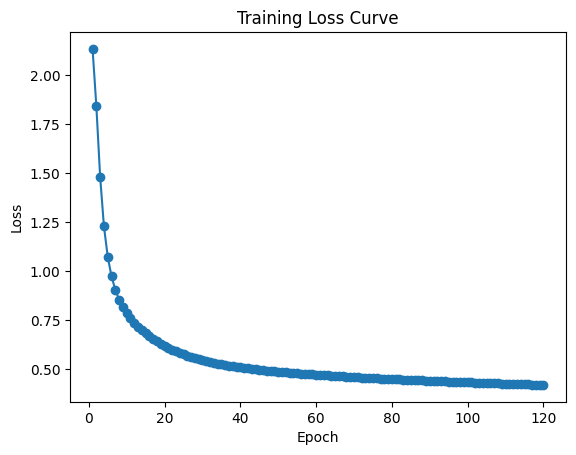

In [124]:
plt.plot(range(1, 121), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [2]:
#answer for question 1.4
#When learning rate is at a moderate rage like 0.1 and 0.01,not only will we get good output in limited epochs,but also 
#we can reach to a good performance faster.When lr is too small like 0.001,within limited steps we may cannot get a good
#output because the model need more steps to converge,but we still can reach to a good performance finally-though we need 
#too many steps.When lr is too large like 1,it is likely that our model's performance oscillates and cannot get a good output,
#because the output cannot converge.
#We can make a conclusion that only by setting learning rate properly can we get a good performance on training models.

In [24]:
#code for question 1.5
#This is a wider model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters:", total_params)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)
Total Trainable Parameters: 1863690


Epoch 1
-------------------------------
loss: 2.307396  [    0/60000]
loss: 0.871352  [ 6400/60000]
loss: 0.562661  [12800/60000]
loss: 0.687149  [19200/60000]
loss: 0.589823  [25600/60000]
loss: 0.498661  [32000/60000]
loss: 0.537491  [38400/60000]
loss: 0.594361  [44800/60000]
loss: 0.588546  [51200/60000]
loss: 0.455800  [57600/60000]
Test Error: 
 Accuracy: 79.6%, Avg loss: 0.540709 

Epoch 2
-------------------------------
loss: 0.424136  [    0/60000]
loss: 0.422318  [ 6400/60000]
loss: 0.367479  [12800/60000]
loss: 0.428811  [19200/60000]
loss: 0.414222  [25600/60000]
loss: 0.439105  [32000/60000]
loss: 0.410221  [38400/60000]
loss: 0.494550  [44800/60000]
loss: 0.510030  [51200/60000]
loss: 0.419943  [57600/60000]
Test Error: 
 Accuracy: 82.5%, Avg loss: 0.463743 

Epoch 3
-------------------------------
loss: 0.330608  [    0/60000]
loss: 0.349209  [ 6400/60000]
loss: 0.307218  [12800/60000]
loss: 0.358426  [19200/60000]
loss: 0.343613  [25600/60000]
loss: 0.410841  [32000/600

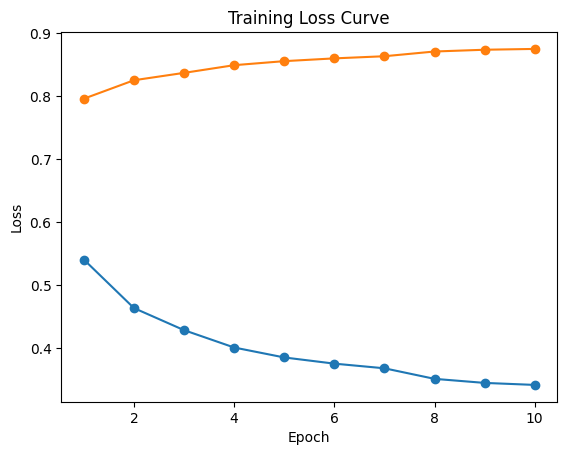

In [27]:
losses = []
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss = test(test_dataloader, model, loss_fn)
    losses.append(loss)
plt.plot(range(1, epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [30]:
#This is a deeper model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),  
            nn.ReLU(),
            nn.Linear(256, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters:", total_params)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)
Total Trainable Parameters: 798474


Epoch 1
-------------------------------
loss: 2.291851  [    0/60000]
loss: 1.105268  [ 6400/60000]
loss: 0.688111  [12800/60000]
loss: 0.769105  [19200/60000]
loss: 0.567580  [25600/60000]
loss: 0.493879  [32000/60000]
loss: 0.548029  [38400/60000]
loss: 0.613203  [44800/60000]
loss: 0.590509  [51200/60000]
loss: 0.459583  [57600/60000]
Test Error: 
 Accuracy: 80.3%, Avg loss: 0.531451 

Epoch 2
-------------------------------
loss: 0.410913  [    0/60000]
loss: 0.460559  [ 6400/60000]
loss: 0.416702  [12800/60000]
loss: 0.434720  [19200/60000]
loss: 0.394074  [25600/60000]
loss: 0.469821  [32000/60000]
loss: 0.408441  [38400/60000]
loss: 0.518384  [44800/60000]
loss: 0.510045  [51200/60000]
loss: 0.420006  [57600/60000]
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.452255 

Epoch 3
-------------------------------
loss: 0.305714  [    0/60000]
loss: 0.364338  [ 6400/60000]
loss: 0.334382  [12800/60000]
loss: 0.358212  [19200/60000]
loss: 0.337037  [25600/60000]
loss: 0.438513  [32000/600

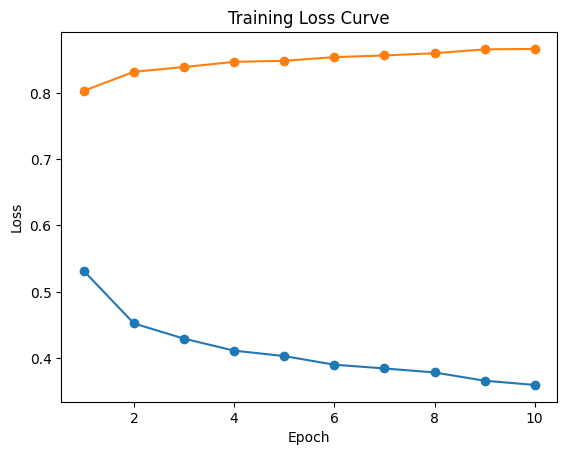

In [33]:
losses = []
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss = test(test_dataloader, model, loss_fn)
    losses.append(loss)
plt.plot(range(1, epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [34]:
#Answer for question 1.5
#We can see that both the approaches of increasing the depth and width of the model increase the training parameters of the model, 
#but as far as the results are concerned these two approaches behave differently
#Here we use a lr of 0.1, which performs best in the original model, and an eppoch setting of 10 to observe the accuracy 
#and loss curves of different models after training.
#It can be seen that compared to the baseline, after training, the approach of increasing the width improves the accuracy of the model
#, and the approach of increasing the depth has a slightly worse model performance than the baseline.
#However,increasing the width greatly increases the model parameters, and increasing the depth slightly increases the parameters 
#While increasing model width improves model performance, the parameters are also greatly increased, revealing a trade-off between 
#computational cost and model performance in model selection and training.

In [84]:
#code for question 1.6
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    mean_gradients = [] 
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mean_gradients.append(torch.mean(torch.stack([p.grad.abs().mean() for p in model.parameters()])).item())
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return mean_gradients
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 1
gradients=[]
for t in range(epochs):
    mean_gradients=train(train_dataloader, model, loss_fn, optimizer)
print("Done!")

loss: 2.300651  [    0/60000]
loss: 0.884644  [ 6400/60000]
loss: 0.576079  [12800/60000]
loss: 0.691893  [19200/60000]
loss: 0.603040  [25600/60000]
loss: 0.518191  [32000/60000]
loss: 0.544318  [38400/60000]
loss: 0.591451  [44800/60000]
loss: 0.618802  [51200/60000]
loss: 0.452078  [57600/60000]
Done!


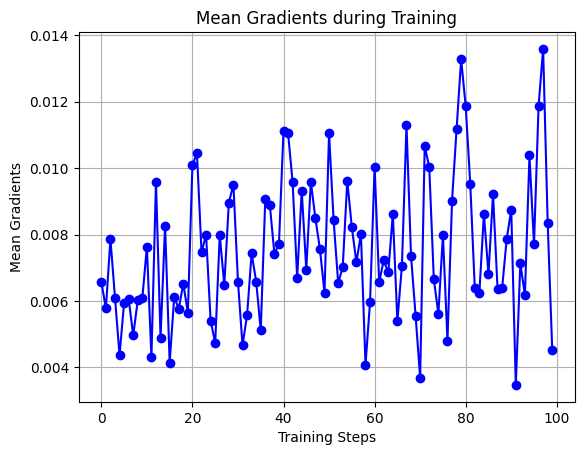

In [88]:
steps=100
training_steps = [i for i in range(steps)]
plt.plot(training_steps, mean_gradients[:steps], marker='o', linestyle='-', color='b')
plt.xlabel('Training Steps')
plt.ylabel('Mean Gradients')
plt.title('Mean Gradients during Training')
plt.grid(True)
plt.show()

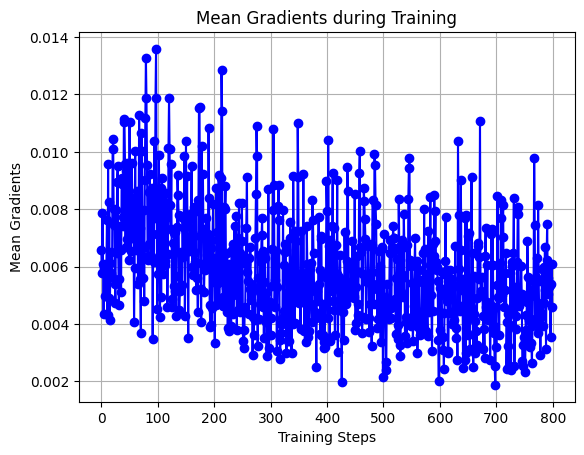

In [90]:
steps=800
training_steps = [i for i in range(steps)]
plt.plot(training_steps, mean_gradients[:steps], marker='o', linestyle='-', color='b')
plt.xlabel('Training Steps')
plt.ylabel('Mean Gradients')
plt.title('Mean Gradients during Training')
plt.grid(True)
plt.show()

In [95]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.8)
epochs = 1
gradients=[]
for t in range(epochs):
    mean_gradients=train(train_dataloader, model, loss_fn, optimizer)
print("Done!")

loss: 2.285686  [    0/60000]
loss: 1.685009  [ 6400/60000]
loss: 1.435848  [12800/60000]
loss: 1.071812  [19200/60000]
loss: 1.124079  [25600/60000]
loss: 1.127894  [32000/60000]
loss: 1.183237  [38400/60000]
loss: 0.948740  [44800/60000]
loss: 1.876494  [51200/60000]
loss: 0.763795  [57600/60000]
Done!


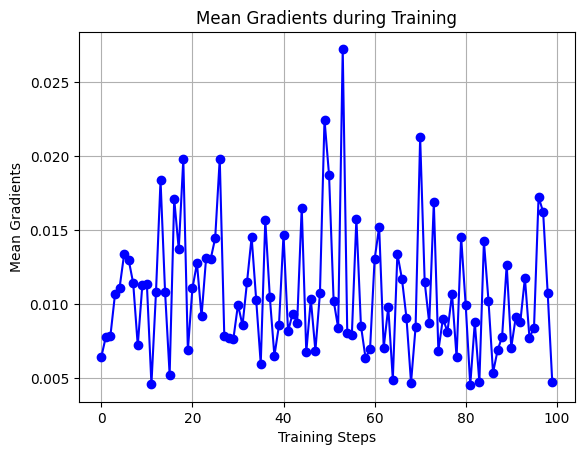

In [97]:
steps=100
training_steps = [i for i in range(steps)]
plt.plot(training_steps, mean_gradients[:steps], marker='o', linestyle='-', color='b')
plt.xlabel('Training Steps')
plt.ylabel('Mean Gradients')
plt.title('Mean Gradients during Training')
plt.grid(True)
plt.show()

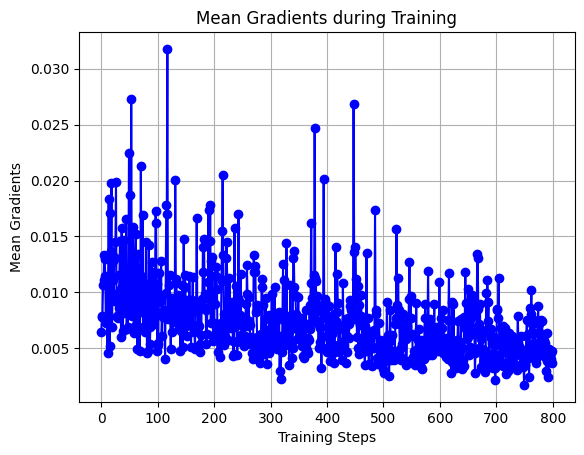

In [98]:
steps=800
training_steps = [i for i in range(steps)]
plt.plot(training_steps, mean_gradients[:steps], marker='o', linestyle='-', color='b')
plt.xlabel('Training Steps')
plt.ylabel('Mean Gradients')
plt.title('Mean Gradients during Training')
plt.grid(True)
plt.show()

In [3]:
#answer for question 1.6 the mean of the gradients decrease.
#We compare the models at two learning rates and set up the images at different learning steps.
#We can find that when the learning step is 100, the mean of the gradient is oscillating, and when 
#the learning step is 800, it is obvious that the mean of the gradient is gradually decreasing in 
#the process of oscillating, which means that the gradient decreases gradually and mildly through training.

In [169]:
#code for question 1.7
class CONVNeuralNetwork(nn.Module):
    def __init__(self):
        super(CONVNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1, bias=False)
        self.linear = nn.Linear(25088, 10, bias=False)
    def set_grad(var):
        def hook(grad):
            var.grad = grad
        return hook
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = x2.view(x2.size(0), -1)  
        x4 = self.linear(x3)
        return x4
model = CONVNeuralNetwork()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters:", total_params)

Total Trainable Parameters: 255632


In [170]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [171]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss,correct

Epoch 1
-------------------------------
loss: 2.309434  [    0/60000]
loss: 0.849713  [ 6400/60000]
loss: 0.665767  [12800/60000]
loss: 0.752747  [19200/60000]
loss: 0.760533  [25600/60000]
loss: 0.593379  [32000/60000]
loss: 0.615206  [38400/60000]
loss: 0.647822  [44800/60000]
loss: 0.790064  [51200/60000]
loss: 0.471145  [57600/60000]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.639007 

Epoch 2
-------------------------------
loss: 0.543718  [    0/60000]
loss: 0.515979  [ 6400/60000]
loss: 0.394376  [12800/60000]
loss: 0.585516  [19200/60000]
loss: 0.526562  [25600/60000]
loss: 0.497756  [32000/60000]
loss: 0.507748  [38400/60000]
loss: 0.614087  [44800/60000]
loss: 0.715681  [51200/60000]
loss: 0.412486  [57600/60000]
Test Error: 
 Accuracy: 80.1%, Avg loss: 0.566311 

Epoch 3
-------------------------------
loss: 0.433677  [    0/60000]
loss: 0.463981  [ 6400/60000]
loss: 0.353289  [12800/60000]
loss: 0.550277  [19200/60000]
loss: 0.482604  [25600/60000]
loss: 0.468853  [32000/600

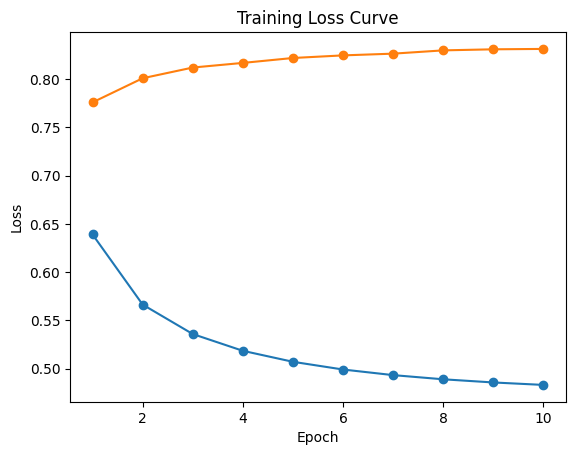

In [172]:
losses = []
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss = test(test_dataloader, model, loss_fn)
    losses.append(loss)
plt.plot(range(1, epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [5]:
#Answer for question 1.7:
#Findings:Convergence:We can see the CNN model convergers faster than MLP,especially the several beginning epochs,
#which means the model learns informantion faster.
#Accuracy:the accuracy of CNN after 10 epochs is 83.1,which is slightly worse than MLPs.
#Number of parameters:the number of parameters of CNN is 255632,much less than the baseline model of MLPs,which means 
#our CNN model is much simpler than MLPs model.
#In conclusion,this CNN models behaves faster learning,much simpler computation and a slightly worse output,which is acceptable
#on some conditions with less arithmetic power and moderate requriment of accuracy.